# Clustering methods
### Rafael Takata García - Montreal

#### Libraries

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### Creation of Dataframes and Data processing

In [527]:
df = pd.read_csv('../data/raw/listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,45728646,Guest suite in Montréal · ★4.69 · 1 bedroom · ...,753212,Georges,NaN,Le Plateau-Mont-Royal,45.538850,-73.560370,Private room,21.0,31,13,2022-11-01,0.34,3,286,0,NaN
1,27438926,Rental unit in Montréal · 1 bedroom · 1 bed · ...,202884942,Abbie,NaN,Rosemont-La Petite-Patrie,45.531530,-73.604250,Entire home/apt,40.0,90,0,NaN,NaN,1,0,0,NaN
2,910248010739253417,Rental unit in Montréal · ★New · 1 bedroom · 1...,65607998,Nabil,NaN,Verdun,45.454424,-73.547104,Entire home/apt,55.0,31,0,NaN,NaN,1,27,0,NaN
3,854389634569393267,Rental unit in Montréal · 2 bedrooms · 2 beds ...,368730072,Nouhaila,NaN,Ville-Marie,45.502018,-73.556932,Entire home/apt,160.0,31,0,NaN,NaN,1,364,0,NaN
4,767425771328334796,Rental unit in Montréal · ★4.80 · Studio · 1 b...,162017221,Damian,NaN,Ville-Marie,45.517690,-73.560770,Entire home/apt,60.0,31,4,2023-08-16,0.39,2,0,4,NaN


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8807 non-null   int64  
 1   name                            8807 non-null   object 
 2   host_id                         8807 non-null   int64  
 3   host_name                       8807 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   8807 non-null   object 
 6   latitude                        8807 non-null   float64
 7   longitude                       8807 non-null   float64
 8   room_type                       8807 non-null   object 
 9   price                           8692 non-null   float64
 10  minimum_nights                  8807 non-null   int64  
 11  number_of_reviews               8807 non-null   int64  
 12  last_review                     69

In [529]:
df.isna().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               8807
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                              115
minimum_nights                       0
number_of_reviews                    0
last_review                       1877
reviews_per_month                 1877
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           4875
dtype: int64

The column `neighbourhood_group` doesn't have any single value so we are going to drop them.

The NaNs in `last_review` is because they have never been reviewed :( and we already have a column that says the number of reviews all time so... We can drop them.

`license` and `host_name` are not really variables that we should encode so let's drop them

In [530]:
df = df.drop(['neighbourhood_group', 'last_review', 'host_name', 'license'], axis=1)
df.head(3)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,45728646,Guest suite in Montréal · ★4.69 · 1 bedroom · ...,753212,Le Plateau-Mont-Royal,45.538850,-73.560370,Private room,21.0,31,13,0.34,3,286,0
1,27438926,Rental unit in Montréal · 1 bedroom · 1 bed · ...,202884942,Rosemont-La Petite-Patrie,45.531530,-73.604250,Entire home/apt,40.0,90,0,NaN,1,0,0
2,910248010739253417,Rental unit in Montréal · ★New · 1 bedroom · 1...,65607998,Verdun,45.454424,-73.547104,Entire home/apt,55.0,31,0,NaN,1,27,0


Now, let's replace the NaNs in `reviews_per_month` with 0 because they have 0 reviews in the last month (and all time)

In [531]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.head(2)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,45728646,Guest suite in Montréal · ★4.69 · 1 bedroom · ...,753212,Le Plateau-Mont-Royal,45.53885,-73.56037,Private room,21.0,31,13,0.34,3,286,0
1,27438926,Rental unit in Montréal · 1 bedroom · 1 bed · ...,202884942,Rosemont-La Petite-Patrie,45.53153,-73.60425,Entire home/apt,40.0,90,0,0.00,1,0,0


Inside name there is the type of property in aribnb so we can extract it and make a new column

In [532]:
df['property'] = df['name'].str.extract(r'(\w+)', expand=False)
df['property'][:3]

0     Guest
1    Rental
2    Rental
Name: property, dtype: object

Let's create a column to see the number of stars (from 1 to 5)

In [533]:
df['stars'] = df['name'].apply(lambda x: x.split('★')[1].split('·')[0] if '★' in x else np.nan)
df['stars'] = df['stars'].replace('New ', 0)

In [534]:
df['stars'] = df['stars'].astype(float)
df['stars'].head(3)

0    4.69
1     NaN
2    0.00
Name: stars, dtype: float64

Let's encode `neighbourhood`, `property` and `room_type`

In [535]:
le = LabelEncoder()

In [536]:
df['room_type'] = le.fit_transform(df['room_type'])
df['neighbourhood'] = le.fit_transform(df['neighbourhood'])
df['property'] = le.fit_transform(df['property'])
df[['room_type', 'neighbourhood', 'property']]

,room_type,neighbourhood,property
0,2,14,10
1,0,25,18
2,0,29,18
3,0,30,18
4,0,30,18
...,...,...,...
8802,0,30,18
8803,0,5,8
8804,0,14,18
8805,0,14,18


#### Fill missing values

In [537]:
df.isna().sum()

id                                   0
name                                 0
host_id                              0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                              115
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
property                             0
stars                             2172
dtype: int64

We only have missing values in `price` and `stars`, let's see the distributions 

<Axes: >

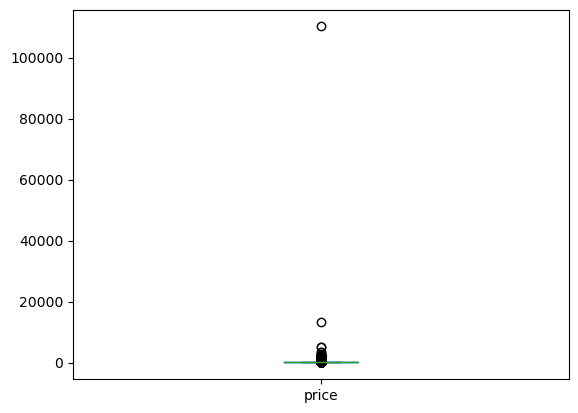

In [538]:
df['price'].plot(kind='box') #We have some big atypical values so we can replace it with the median

In [539]:
df['price'].skew(), df['price'].kurt()

(88.07162830716177, 8035.273043396497)

The kurtosis and skew are extremly high so, we have extreme values that are completely outliers (as you can see)

A recommended method to substitute the values in this cases is using the median since it's way less sensitive to the extreme values.

In [540]:
df['price'] = df['price'].fillna(df['price'].median())
df['price'].head()

0     21.0
1     40.0
2     55.0
3    160.0
4     60.0
Name: price, dtype: float64

Now let's do `stars`

<Axes: >

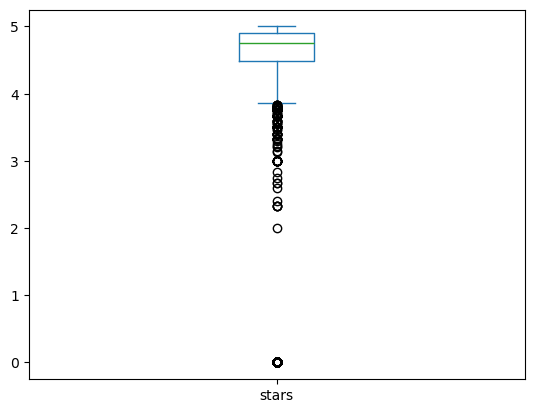

In [541]:
df['stars'].plot(kind = 'box')

In [542]:
df['stars'].skew(), df['stars'].kurt()

(-2.2101080883957556, 3.101236921690485)

But, let's see what the AirBnbs without stars have in common.

In [543]:
df.iloc[np.where(df['stars'].isna())].head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,property,stars
1,27438926,Rental unit in Montréal · 1 bedroom · 1 bed · ...,202884942,25,45.531530,-73.604250,0,40.0,90,0,0.00,1,0,0,18,NaN
3,854389634569393267,Rental unit in Montréal · 2 bedrooms · 2 beds ...,368730072,30,45.502018,-73.556932,0,160.0,31,0,0.00,1,364,0,18,NaN
7,979639365844896994,Rental unit in Montréal · 1 bedroom · 1 bed · ...,484415805,14,45.514912,-73.576093,0,120.0,31,0,0.00,30,37,0,18,NaN
8,23149282,Hostel in Montréal · 1 bedroom · 1 bed · 8 sha...,172058803,14,45.507940,-73.576010,2,35.0,35,2,0.03,15,0,0,13,NaN
9,37522616,Townhouse in Montréal · 4 bedrooms · 4 beds · ...,118132081,15,45.460420,-73.590040,0,110.0,180,0,0.00,1,0,0,22,NaN


so as you can see, it means that they have from little to no reviews at all. With that being said, we can fill the missing values with 0 then.

In [544]:
df['stars'] = df['stars'].fillna(0)

In [545]:
df.isna().sum()

id                                0
name                              0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
property                          0
stars                             0
dtype: int64

We don't have any NaNs left.

finally let's drop the variables that we won't use anymore.

In [546]:
df = df.drop(columns=['name', 'id', 'host_id'])
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,property,stars
0,14,45.538850,-73.560370,2,21.0,31,13,0.34,3,286,0,10,4.69
1,25,45.531530,-73.604250,0,40.0,90,0,0.00,1,0,0,18,0.00
2,29,45.454424,-73.547104,0,55.0,31,0,0.00,1,27,0,18,0.00
3,30,45.502018,-73.556932,0,160.0,31,0,0.00,1,364,0,18,0.00
4,30,45.517690,-73.560770,0,60.0,31,4,0.39,2,0,4,18,4.80


Let's standarize the values, we are going to use the minMax method. 

In [547]:
minmax = MinMaxScaler()

In [548]:
def minmaxf(columns):
    for column in columns:
        df[column] = minmax.fit_transform(df[column].values.reshape(-1, 1))
minmaxf(df.columns)
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,property,stars
0,0.43750,0.455658,0.833121,0.666667,0.000073,0.026690,0.014161,0.007263,0.014599,0.783562,0.000000,0.384615,0.938
1,0.78125,0.431136,0.740124,0.000000,0.000245,0.079181,0.000000,0.000000,0.000000,0.000000,0.000000,0.692308,0.000
2,0.90625,0.172831,0.861238,0.000000,0.000381,0.026690,0.000000,0.000000,0.000000,0.073973,0.000000,0.692308,0.000
3,0.93750,0.332271,0.840407,0.000000,0.001334,0.026690,0.000000,0.000000,0.000000,0.997260,0.000000,0.692308,0.000
4,0.93750,0.384772,0.832274,0.000000,0.000426,0.026690,0.004357,0.008332,0.007299,0.000000,0.017778,0.692308,0.960


### Let's create and train our models. 

We are going to take the stars variable as the Target.

#### Kmeans (Random init)

In [549]:
X_train = df.copy()

In [550]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)

In [551]:
kmR = KMeans(init = 'random').fit(X_train)
labels = kmR.predict(X_train)
centroids = kmR.cluster_centers_

c:\Users\Rafa\anaconda3\envs\analisis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


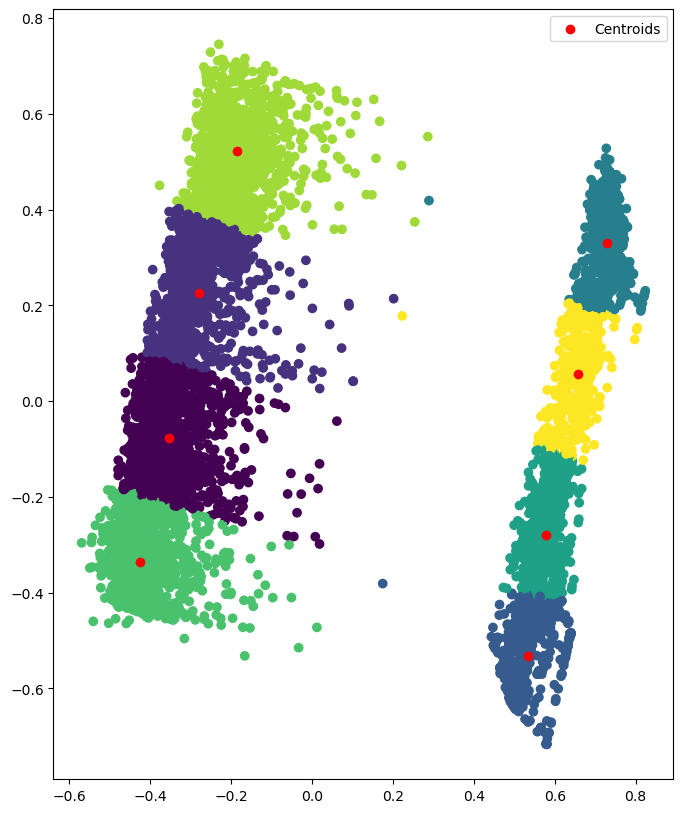

In [552]:
plt.figure(figsize= (8, 10))
plt.scatter(x = X_train[:, 0], y = X_train[:, 1], c = labels)
plt.scatter(centroids[:, 0], centroids[:, 1],  c='red', label='Centroids')
plt.legend()

In [553]:
kmR.inertia_, kmR.score(X_train)

(89.3668897284638, -89.36688972846378)

#### Kmeans++

In [554]:
kmplus = KMeans(init = 'k-means++').fit(X_train)
labelsplus = kmplus.predict(X_train)
centroidsplus = kmplus.cluster_centers_

c:\Users\Rafa\anaconda3\envs\analisis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


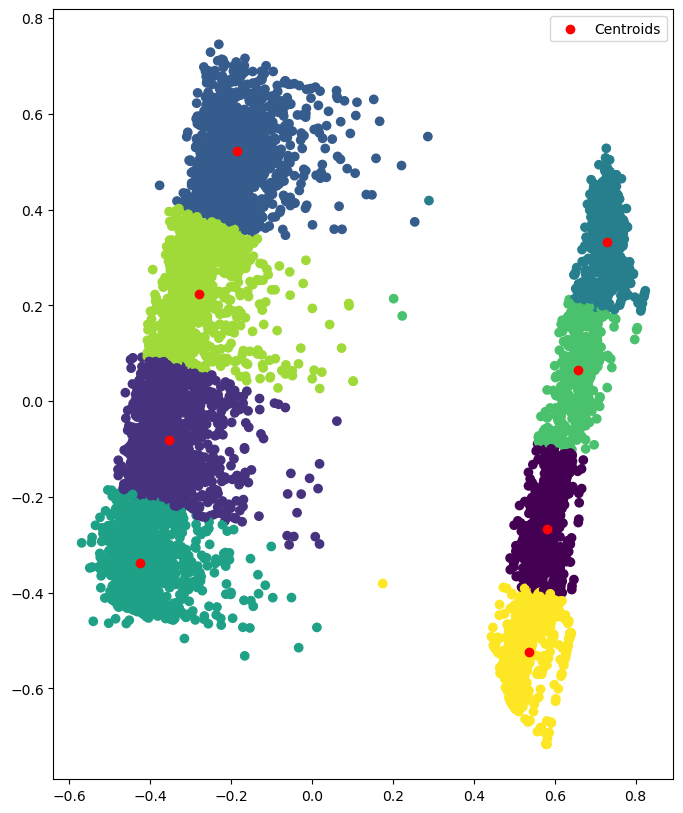

In [555]:
plt.figure(figsize= (8, 10))
plt.scatter(x = X_train[:, 0], y = X_train[:, 1], c = labelsplus)
plt.scatter(centroidsplus[:, 0], centroidsplus[:, 1],  c='red', label='Centroids')
plt.legend()

In [556]:
kmplus.inertia_, kmplus.score(X_train)

(89.28135922176706, -89.28135922176705)

#### DBSCAN

In [557]:
# We don't need to reduce dimensionality here so we can use df
db = DBSCAN(eps = 0.5, min_samples= 5)

In [558]:
dbclusters = db.fit_predict(X_train)
dblabels = db.labels_

In [559]:
n_clusters_ = len(set(dblabels)) - (1 if -1 in dblabels else 0)
n_noise_ = list(dblabels).count(-1)
n_clusters_, n_noise_

(1, 0)

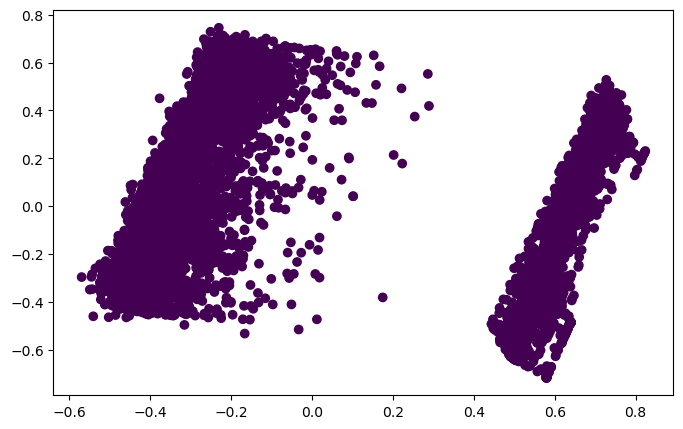

In [560]:
plt.figure(figsize= (8, 5))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=dbclusters)

#### Visualization

In [1]:
tsne = TSNE(n_components= 2, learning_rate= 'auto', init= 'random')
proyectiontsne = tsne.fit_transform(df)
proyectiontsne.shape

NameError: name 'TSNE' is not defined

In [565]:
tsnelabels = kmR.fit_predict(proyectiontsne)

c:\Users\Rafa\anaconda3\envs\analisis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


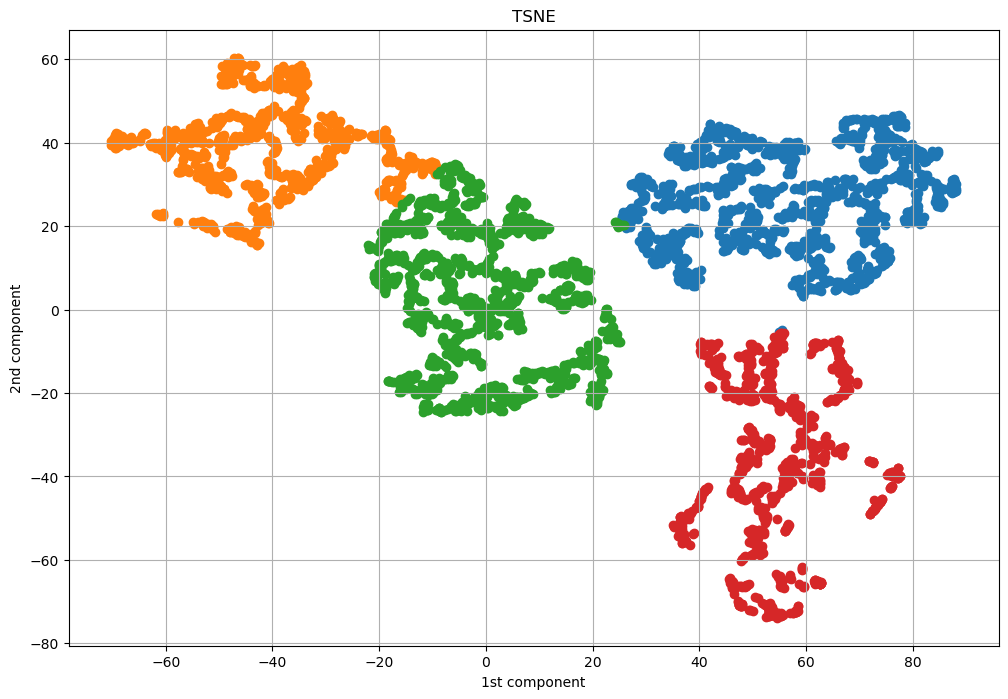

In [568]:
plt.figure(figsize= (12, 8))
for i in range(4):
    plt.scatter(proyectiontsne[tsnelabels == i, 0], proyectiontsne[tsnelabels == i, 1], label = f'cluster {+1}')
plt.title('TSNE')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.grid(True)

### Conclusions

Even with all the AirBnb that are registered, there are a lot that don't have any single review or booking in the last month or even all time. Based in the DBSCAN, we can group most of the properties in just two clusters.